In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from utils import featurize_date_col, TpotAutoml
from sklearn.model_selection import TimeSeriesSplit

sns.set()
%matplotlib inline
pd.options.mode.chained_assignment = None

/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(

In [2]:
# user inputs:
SEED = 13
np.random.seed(SEED)
KEEP_ROWS_FRAC = 1.0 # set to 1 if all rows are meant to be kept
skiprows_func = lambda i: i>0 and np.random.rand() > KEEP_ROWS_FRAC

In [3]:
periods_aggregate = pd.read_csv('data/periods_aggregate_features.csv', skiprows=skiprows_func)

In [4]:
train = pd.read_csv('data/train.csv', usecols=['user_id', 'deal_probability', 'activation_date'],
                   parse_dates=['activation_date'], infer_datetime_format=True)

In [88]:
train_item_id = pd.read_csv('data/train.csv', usecols=['user_id', 'item_id'])

we use only the aggregate periods data to see what features are the most important

In [71]:
all_train = train.merge(periods_aggregate, how='left', on='user_id')

In [7]:
all_train = all_train.sort_values(by='activation_date')

In [8]:
all_train = all_train.drop('activation_date', axis=1)
# all_train = all_train.rename(columns={'activation_date': 'item_activation_date'})
# all_train = featurize_date_col(all_train, 'item_activation_date', remove_when_done=True)

In [9]:
all_train = all_train.set_index('user_id')

In [10]:
#******** NOTE ***** if you use this scorer, you would also need to transform the predict() results the same way
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
def score_func(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_pred = (y_pred - y_pred.mean()) / (y_pred.std()+1e-6)
    y_pred = 1 / (1 + np.exp(-y_pred))
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_pred = scaler.fit_transform(y_pred.reshape((len(y_pred), 1)))
    rmse = np.sqrt(np.mean((y_pred.flatten() - y_true) ** 2))
    return -rmse
scorer = make_scorer(score_func=score_func, greater_is_better=True)

In [11]:
from utils import config_dict

target = 'deal_probability'
TIMEOUT_MINS = None
# SCORING = 'neg_mean_squared_error'
# SCORING = scorer
SCORING = 'r2'
RS=27
X = (all_train.drop(target, axis=1)).values
y = train[target].values
# tss.split(X) is a generator object used for cross-validation
tss = TimeSeriesSplit(n_splits=4)
train_index, test_index = list(tss.split(X))[-1]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [ ]:
tpot = TpotAutoml(mode='regression',
                  max_time_mins=TIMEOUT_MINS,
                  generations = 1, population_size=1,
                  scoring=SCORING,
                  random_state=RS,
                  n_jobs=4,
                  verbosity=2,
                  cv=TimeSeriesSplit(n_splits=3),
                  config_dict=config_dict,                 
                 )

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
gbr = GradientBoostingRegressor()
tpot = GradientBoostingRegressor(alpha=0.75, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=6,
             max_features=0.15000000000000002, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min_samples_split=9,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             presort='auto', random_state=None,
             subsample=0.8500000000000001, verbose=0, warm_start=False)

# tpot = RandomizedSearchCV(estimator=gbr, random_state=RS,
#                           param_distributions=config_dict['sklearn.ensemble.GradientBoostingRegressor'],
#                          n_iter=50,
#                          scoring='r2',
#                          cv=TimeSeriesSplit(n_splits=4),
#                          verbose=1)

In [ ]:
tpot.fit(X_train, y_train)

In [ ]:
# feat_importance_entropy = list(zip(all_train.drop(target, axis=1).columns.values, tpot.best_estimator_.feature_importances_))
feat_importance_entropy = list(zip(all_train.drop(target, axis=1).columns.values, tpot.feature_importances_))

In [ ]:
sorted(list(feat_importance_entropy), key=lambda x:x[1], reverse=True)[:10]

In [ ]:
# top_scores = tpot.get_top_models(return_scores=True)
# print('\ntop cv scores:')
# print(top_scores)
# print('\ntop models')
# print(tpot.top_models)
# print('\nthe best test score:')
test_score = tpot.score(X_test, y_test)
print(test_score)

In [ ]:
rmse = np.sqrt(np.mean((tpot.predict(X_test) - y_test) ** 2))
rmse

0.13907510315042693
0.13940043328804289


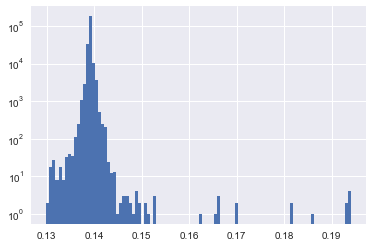

In [18]:
plt.hist(tpot.predict(X_test), log=True, bins=100)
print(tpot.predict(X_test).mean())
print(y_test.mean())

In [ ]:
from analysis import Analysis
ea = Analysis(tpot, X_train, y_train, X_test, y_test,
                           mode='regression', target=target,
                           features=all_train.drop(target, axis=1).columns,
                           test_samples_index=test_index, random_state=RS)

In [ ]:
ea.get_feature_importance(sort=True);

In [ ]:
list(ea.feature_importance.items())[:10]

In [91]:
train_item_id = train_item_id.merge(periods_aggregate, how='left', on='user_id')

In [98]:
train_item_id = train_item_id.drop('user_id', axis=1).set_index('item_id')

In [99]:
means = np.mean(train_item_id.dropna())

In [102]:
train_item_id = train_item_id.fillna(means)

In [75]:
from utils import config_dict

target = 'deal_probability'
TIMEOUT_MINS = None
# SCORING = 'neg_mean_squared_error'
# SCORING = scorer
SCORING = 'r2'
RS=27
X = (all_train.drop(target, axis=1)).values
y = train[target].values
# tss.split(X) is a generator object used for cross-validation
tss = TimeSeriesSplit(n_splits=4)
train_index, test_index = list(tss.split(X))[-1]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [104]:
train_item_id['deal_probability'] = tpot.predict(train_item_id.values)

In [109]:
train_item_id[['deal_probability']].to_csv('predictions/periods_train.csv')

In [115]:
test = pd.read_csv('data/test.csv', usecols=['item_id', 'user_id'])

In [116]:
all_test = test.merge(periods_aggregate, how='left', on='user_id')

In [117]:
all_test = all_test.set_index('item_id').drop('user_id', axis=1)

In [118]:
means = np.mean(all_test.dropna())

In [119]:
all_test = all_test.fillna(means)

In [59]:
# all_test = all_test.rename(columns={'activation_date': 'item_activation_date'})
# all_test = featurize_date_col(all_test, 'item_activation_date', remove_when_done=True)

In [121]:
all_test['deal_probability'] = tpot.predict(all_test.values)

In [124]:
all_test[['deal_probability']].to_csv('predictions/periods.csv')

In [17]:
import pickle
# pickle.dump(tpot, open('predictions/periods_rf.pickle', 'wb'))
tpot = pickle.load(open('predictions/periods_rf.pickle', 'rb'))

/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
test_score = tpot.score(X_test, y_test)
print(test_score)